In [50]:
#@title Configuración inicial
!pip -q install python-docx

import pandas as pd, numpy as np, os, io, zipfile
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from datetime import datetime

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

out_dir = '/content/FuerzaVentasConvenios'
fig_dir = os.path.join(out_dir, 'figuras')
tab_dir = os.path.join(out_dir, 'tablas')
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(tab_dir, exist_ok=True)


In [51]:
#@title Cargar CSV (subir archivo)
uploaded = files.upload()
assert len(uploaded) == 1, "Sube exactamente un archivo CSV"
CSV_FILE = list(uploaded.keys())[0]
print("Archivo recibido:", CSV_FILE)

# Intentos de lectura robustos
read_attempts = [
    dict(sep=None, engine='python', encoding='utf-8'),
    dict(sep=None, engine='python', encoding='latin-1'),
    dict(sep=';', encoding='utf-8', decimal=',', thousands='.'),
    dict(sep=';', encoding='latin-1', decimal=',', thousands='.'),
    dict(sep=',', encoding='utf-8'),
    dict(sep=',', encoding='latin-1'),
]

last_err = None
for kw in read_attempts:
    try:
        df = pd.read_csv(io.BytesIO(uploaded[CSV_FILE]), **kw)
        print("Leído con parámetros:", kw)
        break
    except Exception as e:
        last_err = e
        df = None

if df is None:
    raise last_err

print("Shape:", df.shape)
display(df.head(20))


Saving FuerzaVentasConvenios.csv to FuerzaVentasConvenios (1).csv
Archivo recibido: FuerzaVentasConvenios (1).csv
Leído con parámetros: {'sep': None, 'engine': 'python', 'encoding': 'utf-8'}
Shape: (1000, 10)


,Edad,Genero,CasaPropia,EstadoCiv,Ubicación,Salario,Niños,Historia,Catalogos,MontoDinero
0,Mayor,Mujer,Propia,Soltero,Lejos,47500,0,Alta,6,755
1,Adulto,Hombre,Alquilada,Soltero,Cerca,63600,0,Alta,6,1318
2,Joven,Mujer,Alquilada,Soltero,Cerca,13500,0,Baja,18,296
3,Adulto,Hombre,Propia,Casado,Cerca,85600,1,Alta,18,2436
4,Adulto,Mujer,Propia,Soltero,Cerca,68400,0,Alta,12,1304
5,Joven,Hombre,Propia,Casado,Cerca,30400,0,Baja,6,495
6,Adulto,Mujer,Alquilada,Soltero,Cerca,48100,0,Media,12,782
7,Adulto,Hombre,Propia,Soltero,Cerca,68400,0,Alta,18,1155
8,Adulto,Mujer,Propia,Casado,Cerca,51900,3,Baja,6,158
9,Mayor,Hombre,Propia,Casado,Lejos,80700,0,NaN,18,3034


In [52]:
#@title Vista preliminar, tipos y duplicados
print("📋 Información general del DataFrame:")
print("="*60)
df.info()
print("\nShape:", df.shape)

# === VALORES NULOS Y FALTANTES ===
print("\n🧩 Valores nulos o faltantes:")
print("="*60)
faltantes = df.isnull().sum()
faltantes = faltantes[faltantes > 0].sort_values(ascending=False)
if faltantes.empty:
    print("No hay valores nulos o faltantes.")
else:
    display(faltantes.to_frame("Cantidad de Nulos"))
    print("\nPorcentaje de valores nulos por columna:")
    display((df.isnull().mean() * 100).round(2).to_frame("% Nulos"))

# === DUPLICADOS ===
print("\n📎 Datos duplicados:")
print("="*60)
duplicados = df.duplicated().sum()
print(f"Total de filas duplicadas: {duplicados}")
if duplicados > 0:
    print("Ejemplo de filas duplicadas:")
    display(df[df.duplicated()].head())

# === TIPOS DE DATOS ===
print("\n⚙️ Tipos de datos y conteo:")
print("="*60)
display(df.dtypes.value_counts())

# === DESCRIPTIVO ESTADÍSTICO ===
print("\n📊 Estadísticas descriptivas (numéricas):")
print("="*60)
display(df.describe().T)

# === VARIABLES CATEGÓRICAS ===
print("\n🔤 Variables categóricas (primeras 5 con menos cardinalidad):")
print("="*60)
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols[:5]:
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))
    print("-"*40)



📋 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Edad         1000 non-null   object
 1   Genero       1000 non-null   object
 2   CasaPropia   1000 non-null   object
 3   EstadoCiv    1000 non-null   object
 4   Ubicación    1000 non-null   object
 5   Salario      1000 non-null   int64 
 6   Niños        1000 non-null   int64 
 7   Historia     697 non-null    object
 8   Catalogos    1000 non-null   int64 
 9   MontoDinero  1000 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 78.3+ KB

Shape: (1000, 10)

🧩 Valores nulos o faltantes:


,Cantidad de Nulos
Historia,303



Porcentaje de valores nulos por columna:


,% Nulos
Edad,0.0
Genero,0.0
CasaPropia,0.0
EstadoCiv,0.0
Ubicación,0.0
Salario,0.0
Niños,0.0
Historia,30.3
Catalogos,0.0
MontoDinero,0.0



📎 Datos duplicados:
Total de filas duplicadas: 0

⚙️ Tipos de datos y conteo:


,count
object,6
int64,4



📊 Estadísticas descriptivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
Salario,1000.0,56103.900,30616.314826,10100.0,29975.00,53700.0,77025.0,168800.0
Niños,1000.0,0.934,1.051070,0.0,0.00,1.0,2.0,3.0
Catalogos,1000.0,14.682,6.622895,6.0,6.00,12.0,18.0,24.0
MontoDinero,1000.0,1216.770,961.068613,38.0,488.25,962.0,1688.5,6217.0



🔤 Variables categóricas (primeras 5 con menos cardinalidad):

Edad:
Edad
Adulto    508
Joven     287
Mayor     205
Name: count, dtype: int64
----------------------------------------

Genero:
Genero
Mujer     506
Hombre    494
Name: count, dtype: int64
----------------------------------------

CasaPropia:
CasaPropia
Propia       516
Alquilada    484
Name: count, dtype: int64
----------------------------------------

EstadoCiv:
EstadoCiv
Casado     502
Soltero    498
Name: count, dtype: int64
----------------------------------------

Ubicación:
Ubicación
Cerca    710
Lejos    290
Name: count, dtype: int64
----------------------------------------


In [53]:
print("📋 Lista final de variables:")
print("\nNuméricas:")
for col in num_cols:
    print(" -", col)
print("\nCategóricas:")
for col in cat_cols:
    print(" -", col)


📋 Lista final de variables:

Numéricas:
 - Edad
 - Genero
 - CasaPropia
 - EstadoCiv
 - Ubicación
 - Salario
 - Niños
 - Historia
 - Catalogos
 - MontoDinero

Categóricas:
 - Edad
 - Genero
 - CasaPropia
 - EstadoCiv
 - Ubicación
 - Historia


In [54]:
import pandas as pd

# --- Crear una lista con la información ---
resumen = []

for col in df.columns:
    if df[col].dtype in ['object', 'category']:
        tipo = "Categórica"
        valores = df[col].dropna().unique()
        # Limitar a los primeros 10 valores para que no se haga muy largo
        valores_str = ", ".join(map(str, valores[:10]))
    else:
        tipo = "Numérica"
        desc = df[col].describe()
        valores_str = f"min={desc['min']:.0f}, max={desc['max']:.0f}, mean={desc['mean']:.2f}"

    resumen.append({
        "Columna": col,
        "Tipo": tipo,
        "Variables / Valores": valores_str
    })

# --- Convertir a DataFrame para mostrar como tabla ---
tabla_resumen = pd.DataFrame(resumen)
print("📋 Tabla resumen de columnas y sus variables:")
display(tabla_resumen)


📋 Tabla resumen de columnas y sus variables:


,Columna,Tipo,Variables / Valores
0,Edad,Categórica,"Mayor, Adulto, Joven"
1,Genero,Categórica,"Mujer, Hombre"
2,CasaPropia,Categórica,"Propia, Alquilada"
3,EstadoCiv,Categórica,"Soltero, Casado"
4,Ubicación,Categórica,"Lejos, Cerca"
5,Salario,Numérica,"min=10100, max=168800, mean=56103.90"
6,Niños,Numérica,"min=0, max=3, mean=0.93"
7,Historia,Categórica,"Alta, Baja, Media"
8,Catalogos,Numérica,"min=6, max=24, mean=14.68"
9,MontoDinero,Numérica,"min=38, max=6217, mean=1216.77"


In [55]:
# Reemplazar los valores NaN por la palabra 'Nulo'
df['Historia'] = df['Historia'].fillna('Nulo')

# Confirmar el cambio
print("✅ Valores NaN en 'Historia' reemplazados por 'Nulo'")
print(df['Historia'].value_counts(dropna=False))


✅ Valores NaN en 'Historia' reemplazados por 'Nulo'
Historia
Nulo     303
Alta     255
Baja     230
Media    212
Name: count, dtype: int64


#label encoding

In [56]:
from sklearn.preprocessing import LabelEncoder

# Lista de variables categóricas
cat_cols = ['Edad', 'Genero', 'CasaPropia', 'EstadoCiv', 'Ubicación', 'Historia']

# Crear copia del DataFrame
df_encoded = df.copy()

# Aplicar Label Encoding a cada columna categórica
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = df_encoded[col].astype(str)  # manejar NaN como 'nan'
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"✅ Columna '{col}' codificada: {list(le.classes_)}")

# Mostrar las primeras filas del DataFrame transformado
print("\n📊 DataFrame codificado (primeras 5 filas):")
display(df_encoded.head())


✅ Columna 'Edad' codificada: ['Adulto', 'Joven', 'Mayor']
✅ Columna 'Genero' codificada: ['Hombre', 'Mujer']
✅ Columna 'CasaPropia' codificada: ['Alquilada', 'Propia']
✅ Columna 'EstadoCiv' codificada: ['Casado', 'Soltero']
✅ Columna 'Ubicación' codificada: ['Cerca', 'Lejos']
✅ Columna 'Historia' codificada: ['Alta', 'Baja', 'Media', 'Nulo']

📊 DataFrame codificado (primeras 5 filas):


,Edad,Genero,CasaPropia,EstadoCiv,Ubicación,Salario,Niños,Historia,Catalogos,MontoDinero
0,2,1,1,1,1,47500,0,0,6,755
1,0,0,0,1,0,63600,0,0,6,1318
2,1,1,0,1,0,13500,0,1,18,296
3,0,0,1,0,0,85600,1,0,18,2436
4,0,1,1,1,0,68400,0,0,12,1304


In [57]:
print(df_encoded.dtypes)
print(df.dtypes)
# O para más información:
# df_encoded.info()

Edad           int64
Genero         int64
CasaPropia     int64
EstadoCiv      int64
Ubicación      int64
Salario        int64
Niños          int64
Historia       int64
Catalogos      int64
MontoDinero    int64
dtype: object
Edad           object
Genero         object
CasaPropia     object
EstadoCiv      object
Ubicación      object
Salario         int64
Niños           int64
Historia       object
Catalogos       int64
MontoDinero     int64
dtype: object


📊 Análisis de Distribuciones Numéricas y Detección de Outliers (IQR)

🔹 Salario
Rango IQR: 29975.00 – 77025.00 (IQR=47050.00)
Límites: [-40600.00, 147600.00]
Outliers detectados: 1 (0.1%)


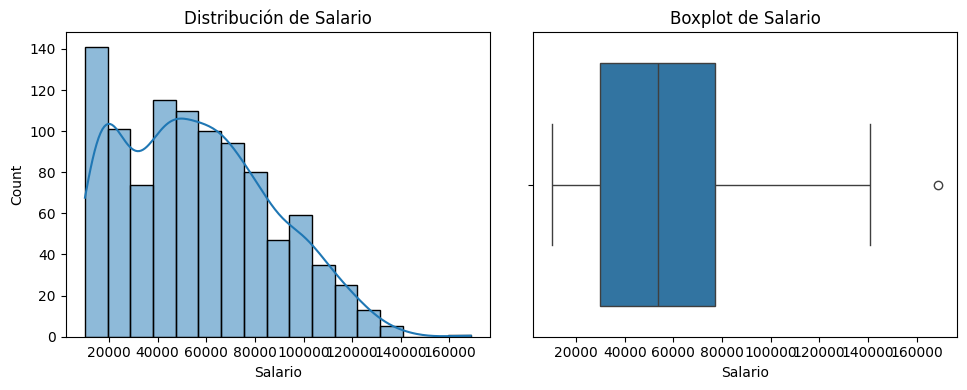


🔹 Niños
Rango IQR: 0.00 – 2.00 (IQR=2.00)
Límites: [-3.00, 5.00]
Outliers detectados: 0 (0.0%)


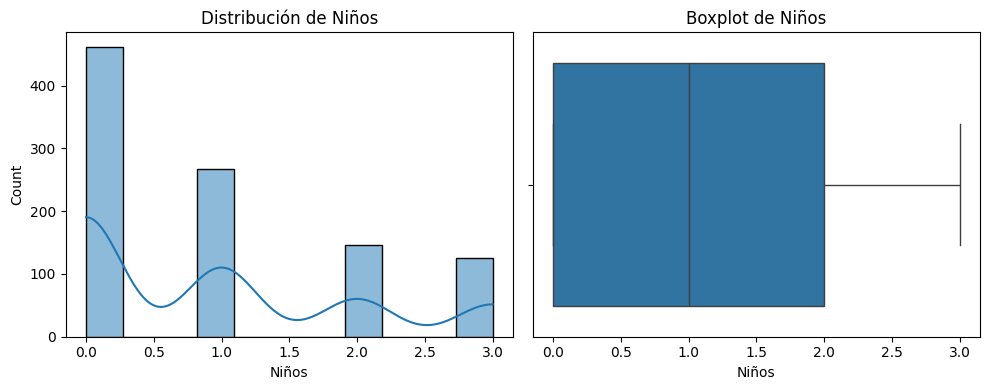


🔹 Catalogos
Rango IQR: 6.00 – 18.00 (IQR=12.00)
Límites: [-12.00, 36.00]
Outliers detectados: 0 (0.0%)


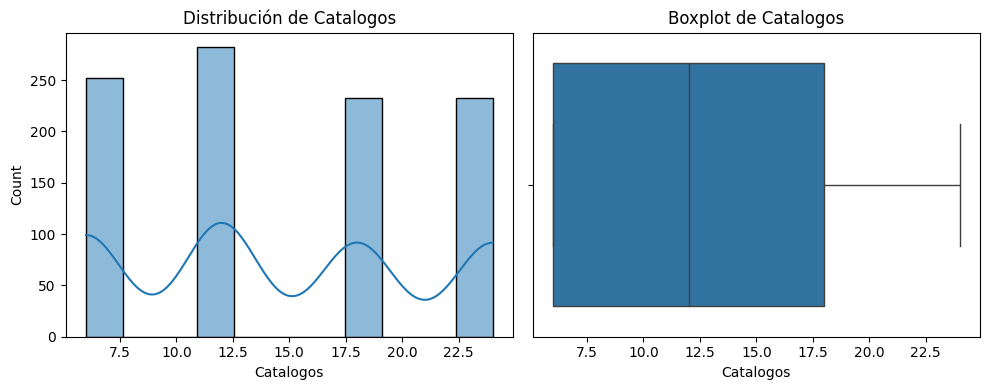


🔹 MontoDinero
Rango IQR: 488.25 – 1688.50 (IQR=1200.25)
Límites: [-1312.12, 3488.88]
Outliers detectados: 27 (2.7%)


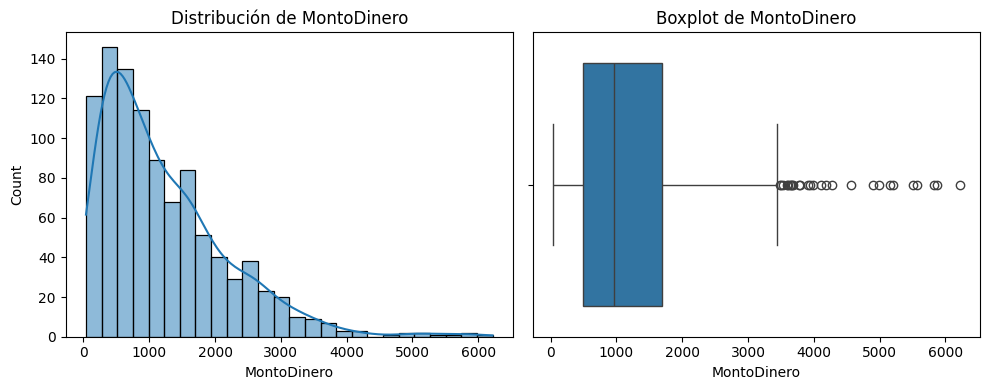


📋 Resumen de outliers por variable:


,Variable,Q1,Q3,IQR,Límite inferior,Límite superior,Outliers (#),% Outliers
0,Salario,29975.00,77025.0,47050.00,-40600.00,147600.00,1,0.1
1,Niños,0.00,2.0,2.00,-3.00,5.00,0,0.0
2,Catalogos,6.00,18.0,12.00,-12.00,36.00,0,0.0
3,MontoDinero,488.25,1688.5,1200.25,-1312.12,3488.88,27,2.7


In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1️⃣ Definir tipos correctamente ===
# ⚠️ Ajusta esta lista según tu dataset real
cat_cols = ['Edad', 'Genero', 'CasaPropia', 'EstadoCiv', 'Ubicación', 'Historia']
num_cols = ['Salario', 'Niños', 'Catalogos', 'MontoDinero']

resumen_outliers = []

print("📊 Análisis de Distribuciones Numéricas y Detección de Outliers (IQR)")
print("="*80)

# === 2️⃣ Calcular IQR solo para variables numéricas ===
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    n_outliers = outliers.shape[0]
    pct_outliers = round((n_outliers / len(df)) * 100, 2)

    # Guardar resultados
    resumen_outliers.append({
        "Variable": col,
        "Q1": round(Q1, 2),
        "Q3": round(Q3, 2),
        "IQR": round(IQR, 2),
        "Límite inferior": round(lower_bound, 2),
        "Límite superior": round(upper_bound, 2),
        "Outliers (#)": n_outliers,
        "% Outliers": pct_outliers
    })

    # --- Mostrar resumen en consola ---
    print(f"\n🔹 {col}")
    print(f"Rango IQR: {Q1:.2f} – {Q3:.2f} (IQR={IQR:.2f})")
    print(f"Límites: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Outliers detectados: {n_outliers} ({pct_outliers}%)")

    # === 3️⃣ Graficar distribución y boxplot ===
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribución de {col}")
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.show()

# === 4️⃣ Resumen tabular de outliers ===
resumen_df = pd.DataFrame(resumen_outliers)
print("\n📋 Resumen de outliers por variable:")
display(resumen_df)


In [62]:
# --- Normalizar valores "nulos" expresados como texto ---
NULL_STRINGS = {"nulo", "null", "na", "n/a", "none", "", "sin dato", "missing"}
def to_nan(x):
    if isinstance(x, str) and x.strip().lower() in NULL_STRINGS:
        return np.nan
    return x

for c in ['Edad', 'Historia', 'Genero', 'CasaPropia', 'EstadoCiv', 'Ubicación']:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].map(to_nan)


📏 Límites IQR usados para winsorizar:
 - Salario: [-36850.0, 149950.0]
 - Niños: [-3.0, 5.0]
 - Catalogos: [3.0, 27.0]
 - MontoDinero: [-1373.0, 3547.0]


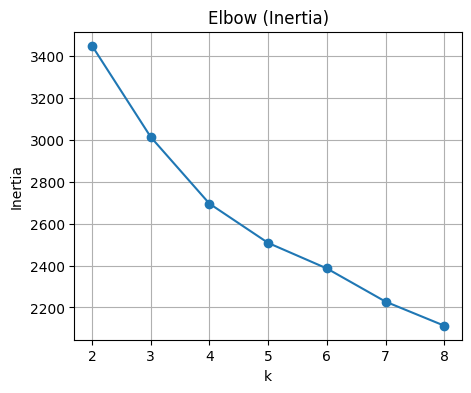

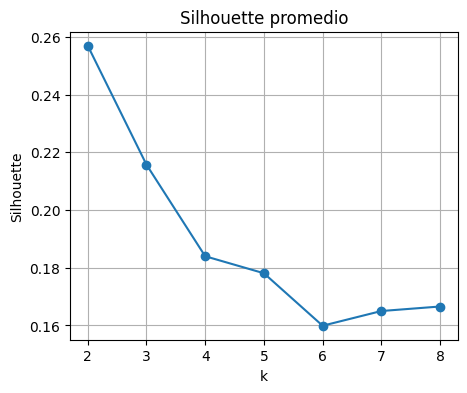


🔬 PCA 3D - Varianza explicada por componente: [0.4199 0.1624 0.1237]
🔢 Varianza explicada acumulada (3D): 0.7061


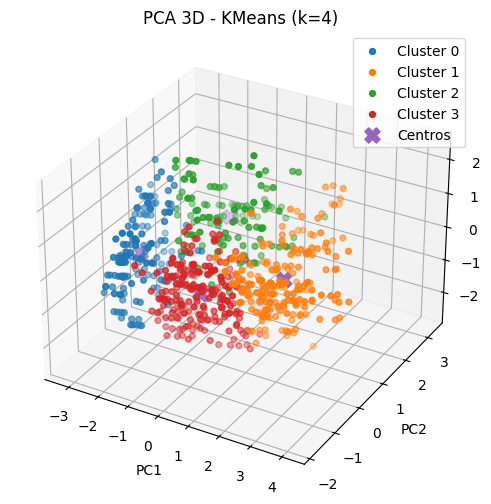


✅ Primeras filas con cluster asignado:
     Edad  Genero CasaPropia EstadoCiv Ubicación  Salario  Niños Historia  \
0   Mayor   Mujer     Propia   Soltero     Lejos    47500      0     Alta   
1  Adulto  Hombre  Alquilada   Soltero     Cerca    63600      0     Alta   
2   Joven   Mujer  Alquilada   Soltero     Cerca    13500      0     Baja   
3  Adulto  Hombre     Propia    Casado     Cerca    85600      1     Alta   
4  Adulto   Mujer     Propia   Soltero     Cerca    68400      0     Alta   

   Catalogos  MontoDinero  cluster  
0          6          755        3  
1          6         1318        3  
2         18          296        0  
3         18         2436        1  
4         12         1304        3  

🔢 Conteo de registros por cluster:
cluster
0    167
1    198
2    126
3    206
Name: count, dtype: int64

📊 Promedios de variables numéricas por cluster:
              Salario     Niños  Catalogos  MontoDinero
cluster                                                
0       

In [65]:
# ===========================================
# PREPARACIÓN + KMEANS (k=4) + PCA 3D
# ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# ------------------------------------------------------
# 0) CONFIGURACIÓN DE COLUMNAS (AJUSTA SI ES NECESARIO)
# ------------------------------------------------------
num_cols = ['Salario', 'Niños', 'Catalogos', 'MontoDinero']  # numéricas reales
ord_cols_spec = {  # categóricas con orden
    'Edad': ['Joven', 'Adulto', 'Mayor'],
    'Historia': ['Baja', 'Media', 'Alta'],  # Baja < Media < Alta
}
nom_cols = ['Genero', 'CasaPropia', 'EstadoCiv', 'Ubicación']  # categóricas nominales

# ------------------------------------------------------
# 1) LIMPIEZA: Ignorar “Nulo” (filas) y validar columnas
# ------------------------------------------------------
df_clean = df.copy()

def to_nan_if_nulo(x):
    if isinstance(x, str) and x.strip().lower() == "nulo":
        return np.nan
    return x

cols_all_cat = list(ord_cols_spec.keys()) + nom_cols
for c in cols_all_cat:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].map(to_nan_if_nulo)

# Eliminar filas con NaN en categóricas clave
present_cat_cols = [c for c in cols_all_cat if c in df_clean.columns]
df_clean = df_clean.dropna(subset=present_cat_cols)

# ------------------------------------------------------
# 2) WINSORIZACIÓN POR IQR (solo numéricas reales)
# ------------------------------------------------------
def winsorize_iqr(data, cols):
    X = data.copy()
    limites = {}
    for col in cols:
        if col not in X.columns:
            continue
        s = pd.to_numeric(X[col], errors='coerce')
        Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        X[col] = s.clip(lower, upper)
        limites[col] = (round(lower, 3), round(upper, 3))
    return X, limites

df_clean, limites_iqr = winsorize_iqr(df_clean, [c for c in num_cols if c in df_clean.columns])

print("📏 Límites IQR usados para winsorizar:")
for k, (lo, up) in limites_iqr.items():
    print(f" - {k}: [{lo}, {up}]")

# ------------------------------------------------------
# 3) PREPROCESAMIENTO (imputación + encoding + escalado)
# ------------------------------------------------------
ord_cols = [c for c in ord_cols_spec.keys() if c in df_clean.columns]
ord_categories = [ord_cols_spec[c] for c in ord_cols]
num_cols_present = [c for c in num_cols if c in df_clean.columns]
nom_cols_present = [c for c in nom_cols if c in df_clean.columns]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Robusto ante valores residuales desconocidos si aparecieran
ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(
        categories=ord_categories,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop=None))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_present),
        ("ord", ordinal_transformer, ord_cols),
        ("nom", nominal_transformer, nom_cols_present),
    ],
    remainder='drop'
)

# ------------------------------------------------------
# 4) (Opcional) EVALUAR K (elbow + silhouette) SOLO REFERENCIA
# ------------------------------------------------------
def evaluar_k(X, k_min=2, k_max=8, random_state=42):
    ks, inertias, silhouettes = [], [], []
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        ks.append(k)
        sil = silhouette_score(X, labels) if len(set(labels)) > 1 and X.shape[0] > k else np.nan
        silhouettes.append(sil)

    # Elbow
    plt.figure(figsize=(5,4))
    plt.plot(ks, inertias, marker='o')
    plt.title("Elbow (Inertia)")
    plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(True)
    plt.show()

    # Silhouette
    plt.figure(figsize=(5,4))
    plt.plot(ks, silhouettes, marker='o')
    plt.title("Silhouette promedio")
    plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True)
    plt.show()

    res = pd.DataFrame({"k": ks, "inertia": inertias, "silhouette": silhouettes})
    return res

# ------------------------------------------------------
# 5) FIT-TRANSFORM + PCA 3D + KMEANS (k=4 FIJO)
# ------------------------------------------------------
X_pre = preprocess.fit_transform(df_clean)

# (Opcional) ver referencia de k, pero graficamente definiremos k=4
_ = evaluar_k(X_pre, k_min=2, k_max=8)

# PCA 3D para visualización
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_pre)
var_exp = pca.explained_variance_ratio_
print("\n🔬 PCA 3D - Varianza explicada por componente:", np.round(var_exp, 4))
print("🔢 Varianza explicada acumulada (3D):", round(var_exp.sum(), 4))

# Entrenar K-Means con k=4 (sugerido gráficamente)
k_final = 4
km_final = KMeans(n_clusters=k_final, n_init="auto", random_state=42)
labels_final = km_final.fit_predict(X_pre)

# Proyectar centros al espacio PCA para graficarlos
centers_pca = pca.transform(km_final.cluster_centers_)

# --- Gráfico 3D (un solo plot) ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (necesario para 3D)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(projection='3d')

# Dibujar puntos por cluster (sin especificar colores; usa los defaults)
for cl in range(k_final):
    mask = (labels_final == cl)
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], s=18, label=f'Cluster {cl}')

# Dibujar centros (marcadores más grandes)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], centers_pca[:, 2],
           s=120, marker='X', label='Centros')

ax.set_title('PCA 3D - KMeans (k=4)')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend()
plt.show()

# ------------------------------------------------------
# 6) RESULTADOS: CLUSTERS + RESÚMENES
# ------------------------------------------------------
df_clusters = df_clean.copy()
df_clusters['cluster'] = labels_final

print("\n✅ Primeras filas con cluster asignado:")
print(df_clusters.head())

print("\n🔢 Conteo de registros por cluster:")
print(df_clusters['cluster'].value_counts().sort_index())

# Resumen numéricas por cluster (promedios)
if num_cols_present:
    res_num = df_clusters.groupby('cluster')[num_cols_present].mean(numeric_only=True)
    print("\n📊 Promedios de variables numéricas por cluster:")
    print(res_num)

# Modas categóricas por cluster
def moda_serie(s):
    return s.mode(dropna=True).iloc[0] if not s.mode(dropna=True).empty else np.nan

if len(ord_cols):
    res_cat_ord = df_clusters.groupby('cluster')[ord_cols].agg(moda_serie)
    print("\n🏷️ Modas de variables categóricas (ordinales) por cluster:")
    print(res_cat_ord)

if len(nom_cols_present):
    res_cat_nom = df_clusters.groupby('cluster')[nom_cols_present].agg(moda_serie)
    print("\n🏷️ Modas de variables categóricas (nominales) por cluster:")
    print(res_cat_nom)

# (Opcional) Exportar
# df_clusters.to_csv("clientes_con_clusters.csv", index=False)
# if num_cols_present: res_num.to_csv("resumen_numericas_por_cluster.csv")
# if len(ord_cols): res_cat_ord.to_csv("resumen_categorias_ordinales_por_cluster.csv")
# if len(nom_cols_present): res_cat_nom.to_csv("resumen_categorias_nominales_por_cluster.csv")


In [66]:
import json
from datetime import datetime
import numpy as np
import os

# ====== CONFIG: listas de columnas de TU pipeline ======
num_cols = ['Salario', 'Niños', 'Catalogos', 'MontoDinero']
ord_cols_spec = {
    'Edad': ['Joven','Adulto','Mayor'],
    'Historia': ['Baja','Media','Alta']
}
nom_cols = ['Genero','CasaPropia','EstadoCiv','Ubicación']

# ====== RUTAS ======
OUT_DIR = "PROYECTOWEB/data"
OUT_PATH = os.path.join(OUT_DIR, "reglas_asociacion.json")
os.makedirs(OUT_DIR, exist_ok=True)

# ====== helpers ======
def get_transformer_by_name(column_transformer, name):
    for nm, trans, cols in column_transformer.transformers_:
        if nm == name:
            return trans, cols
    return None, None

# ====== 1) Extraer transformadores ya *fiteados* ======
num_trf, num_used = get_transformer_by_name(preprocess, "num")
ord_trf, ord_used = get_transformer_by_name(preprocess, "ord")
nom_trf, nom_used = get_transformer_by_name(preprocess, "nom")

# Pipelines internos
num_pipe = num_trf
ord_pipe = ord_trf
nom_pipe = nom_trf

# Step objects
from sklearn.pipeline import Pipeline
def get_step(pipe: Pipeline, name: str):
    return dict(pipe.named_steps)[name]

num_scaler = get_step(num_pipe, "scaler")
ord_encoder = get_step(ord_pipe, "ordinal")
nom_onehot = get_step(nom_pipe, "onehot")

# ====== 2) Construir feature_space para la UI ======
feature_space = []

# a) NUM: min/max/mean/std desde df_clean (sin escalar)
for c in num_used:
    col = pd.to_numeric(df_clean[c], errors='coerce')
    feature_space.append({
        "name": c,
        "label": c if c!="MontoDinero" else "Monto de dinero",
        "type": "num",
        "min": float(np.nanmin(col)),
        "max": float(np.nanmax(col)),
        "mean": float(np.nanmean(col)),
        "std": float(np.nanstd(col, ddof=0)) if hasattr(num_scaler, "scale_") else 1.0
    })

# b) ORD: orden real desde el encoder (garantiza coincidir con entrenamiento)
if ord_encoder is not None and hasattr(ord_encoder, "categories_"):
    for c, cats in zip(ord_used, ord_encoder.categories_):
        feature_space.append({
            "name": c,
            "label": c,
            "type": "ord",
            "order": [str(x) for x in cats]
        })

# c) NOM: listas cerradas desde OneHotEncoder
if nom_onehot is not None and hasattr(nom_onehot, "categories_"):
    for c, cats in zip(nom_used, nom_onehot.categories_):
        feature_space.append({
            "name": c,
            "label": c,
            "type": "nom",
            "values": [str(x) for x in cats]
        })

# ====== 3) Centroides en el MISMO orden y espacio que feature_space ======
# ColumnTransformer output order: [num (as-is), ord (1 por col), nom (one-hot expandido)]
# KMeans fue entrenado sobre X_pre con ese orden -> tomamos cluster_centers_ tal cual
centroids = []
for idx, vec in enumerate(km_final.cluster_centers_):
    centroids.append({
        "cluster": int(idx),
        "vector": [float(x) for x in vec.tolist()]
    })

# ====== 4) Armar JSON ======
payload = {
    "version": "1.0",
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "k": int(km_final.n_clusters),
    "feature_space": feature_space,
    "centroids": centroids
}

with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print(f"✅ Reglas exportadas a: {OUT_PATH}")
print(f"Dimensión del espacio: {km_final.cluster_centers_.shape[1]}")


✅ Reglas exportadas a: PROYECTOWEB/data/reglas_asociacion.json
Dimensión del espacio: 14
